In [1]:
import pandas as pd
# import modin.pandas as mpd
import numpy as np
import datetime
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
import mplfinance as mpf
from multiprocessing import Pool
from contextlib import contextmanager
from joblib import Parallel, delayed
from IPython.display import clear_output
# import dill as pickle
import pickle
import time

In [2]:
# causis api
from causis_api.const import get_version
from causis_api.const import login
login.username = 'shuai.song'
login.password = 'Tsinghua2022'
login.version = get_version()
from causis_api.data import *
from causis_api.tool import *

#### Stock Data Preparation
The strategy is executed on identical base positions. In this case, the base positions are components of CSI 500.

+ CST500 components weights

In [3]:
index_weights = pd.read_pickle('./dataset/tmp_position.pkl')

Arrange_dates = list(index_weights['df_t0_trade'].loc[index_weights['df_t0_trade']==False].index)
Arrange_dates.append(pd.to_datetime('2022-07-08 00:00:00'))

stock_weights = index_weights['df_pos'].transpose()

In [4]:
Weight_Matrix = index_weights['df_pos'].transpose()

for d in Weight_Matrix.columns:
    Weight_Matrix[d] = Weight_Matrix[d] / Weight_Matrix[d].sum()

Weight_Matrix = Weight_Matrix.transpose()

+ Data of the base positions (daily, min_bars, price & volumes needed) has been prepared and is stored in ./CST500_1min.pkl.

In [5]:
Base_Pos = pd.read_pickle('./dataset/CSI500_minute1.pkl')

+ Data Patches

In [6]:
new_patch = False

## Omitted symbols in Local Data (potential)
for id in tqdm(Weight_Matrix.columns, desc='Patching1'):
    if id not in Base_Pos.keys():
        df = get_price(id, '2019-11-29', '2022-07-08', 'minute1')
        if df.shape[0]:
            df = df.set_index('CLOCK', drop=False)
            Base_Pos[id] = df
            new_patch = True
        else:
            Base_Pos[id] = df
            new_patch = True

## Column 'CLOCK' Error 1 (potential)
for symbol in tqdm(Base_Pos.keys(), desc='Patching2'):
    if Base_Pos[symbol].shape[0]:
        if isinstance(Base_Pos[symbol]['CLOCK'][0], float):
            Base_Pos[symbol]['CLOCK'] = list(Base_Pos[symbol].index)
            new_patch = True

## Column 'CLOCK' Error 2 (potential)
for symbol in tqdm(Base_Pos.keys(), desc='Patching3'):
    if Base_Pos[symbol].shape[0]:
        if isinstance(Base_Pos[symbol]['CLOCK'][0], int):
            df = get_price(str(symbol), '2019-11-29', '2022-07-08', 'minute1')
            if df.shape[0]:
                df = df.set_index('CLOCK', drop=False)
                Base_Pos[symbol] = df
                new_patch = True

if new_patch:
    with open('./dataset/CSI500_minute1.pkl', 'wb') as f:
        pickle.dump(Base_Pos, f, pickle.HIGHEST_PROTOCOL)
    print("New Patch")

else:
    print("No New Patch")

Patching3: 100%|██████████| 774/774 [00:00<00:00, 85978.90it/s]

No New Patch


#### Global Environment Variables
+ Global Settings of Strategy and Backtest Environment

In [7]:
## KDJ Indicator
KDJ_WIN = 9

## MACD Indicator
P_S_EMA_WIN = 12
P_L_EMA_WIN = 26
DEA_WIN = 9

## Super Trend Indicator
ATR_WIN = 60
STD_MULTIPLIER = 3

## BackTest & Simulation Parameters
ACCOUNT = 1e6

## Plot Settings
COLORS = ['darkorange', 'cyan', 'royalblue', 'deeppink', 'indianred', 'limegreen']

#### Technical Features
+ Function *technical_analysis* calculates all the technical features we need, most important of which are 3 signals and fluctuations.
+ Function *tri_forks_filter* aggregates above four features and generates execution signals.

In [8]:
@contextmanager 
def timer(name: str, _align, _log): # ⏱
    s = time.time()
    yield
    elapsed = time.time() - s
    if _log:
        print(f"{ '[' + name + ']' :{_align}} | {time.strftime('%Y-%m-%d %H:%M:%S')} Done | Using {elapsed: .3f} seconds")

In [9]:
def technical_analysis(stmp, log = True):
    stmp = stmp.loc[~stmp['CLOCK'].duplicated()]
    
    with timer('BS_price & ATR', 20, log):
        ## Base Position Price
        stmp['BS_price'] = stmp['CLOSE'].shift(1)

        ## ATR
        TR = []
        TR.append(stmp['HIGH'][0] - stmp['LOW'][0])
        for i in range(1, stmp.shape[0]): 
            TR.append( max( stmp['HIGH'][i]-stmp['LOW'][i], np.abs(stmp['HIGH'][i]-stmp['CLOSE'][i-1]), np.abs(stmp['LOW'][i]-stmp['CLOSE'][i-1])) )

        stmp['TR'] = TR
        stmp['ATR'] = stmp['TR'].rolling(ATR_WIN, min_periods=1).mean() 
        

    with timer('KDJ Indicator', 20, log):
        ## J line
        stmp['RSV'] = (stmp['CLOSE'] - stmp['LOW'].rolling(KDJ_WIN, min_periods=1).min().shift(1)) \
                    / (stmp['HIGH'].rolling(KDJ_WIN, min_periods=1).max().shift(1)-stmp['LOW'].rolling(KDJ_WIN, min_periods=1).min().shift(1))
        stmp['RSV'] = stmp['RSV'].replace([np.inf, -np.inf], np.nan).fillna(0.5)*100

        K_t = []
        D_t = []
        J_t = []
        K_t.append(50)
        D_t.append(50)
        J_t.append(50)

        for i in range(1, stmp.shape[0]):
            K_t.append(K_t[i-1]*2/3 + stmp['RSV'][i]/3)
            D_t.append(D_t[i-1]*2/3 + K_t[i]/3)
            J_t.append(3*K_t[i] - 2*D_t[i])

        stmp['J'] = J_t
    

    with timer('MACD', 20, log):
        ## MACD
        DIF = stmp['CLOSE'].ewm(span=P_S_EMA_WIN, adjust=False).mean() - stmp['CLOSE'].ewm(span=P_L_EMA_WIN, adjust=False).mean()
        DEA = DIF.ewm(span=DEA_WIN, adjust=False).mean()
        stmp['MACD'] = 2*(DIF - DEA)

        stmp['MACD_diff'] = np.sign(stmp['MACD'].diff()).fillna(0)
        stmp['MACD_color'] = np.zeros(stmp.shape[0])
        stmp['MACD_color'].loc[(stmp['MACD']>0) & (stmp['MACD_diff']>0)] =  1 # Deep Red
        stmp['MACD_color'].loc[(stmp['MACD']>0) & (stmp['MACD_diff']<0)] =  2 # Light Red
        stmp['MACD_color'].loc[(stmp['MACD']<0) & (stmp['MACD_diff']<0)] = -1 # Deep Green
        stmp['MACD_color'].loc[(stmp['MACD']<0) & (stmp['MACD_diff']>0)] = -2 # Light Green
        # for plotting
        stmp['MACD_dr'] = np.zeros(stmp.shape[0])
        stmp['MACD_lr'] = np.zeros(stmp.shape[0])
        stmp['MACD_dg'] = np.zeros(stmp.shape[0])
        stmp['MACD_lg'] = np.zeros(stmp.shape[0])
        stmp['MACD_dr'].loc[stmp['MACD_color']== 1] = stmp.loc[stmp['MACD_color']== 1]['MACD']
        stmp['MACD_lr'].loc[stmp['MACD_color']== 2] = stmp.loc[stmp['MACD_color']== 2]['MACD']
        stmp['MACD_dg'].loc[stmp['MACD_color']==-1] = stmp.loc[stmp['MACD_color']==-1]['MACD']
        stmp['MACD_lg'].loc[stmp['MACD_color']==-2] = stmp.loc[stmp['MACD_color']==-2]['MACD']

    with timer('Super Trend', 20, log):
        ## Super Trend
        stmp['h12'] = (stmp['HIGH'] + stmp['LOW'])/2
        stmp['bub'] = stmp['h12'] + STD_MULTIPLIER*stmp['ATR']
        stmp['blb'] = stmp['h12'] - STD_MULTIPLIER*stmp['ATR']

        UB = []
        LB = []
        UB.append(stmp['bub'][0])
        LB.append(stmp['blb'][0])

        for i in range(1, stmp.shape[0]):
            if stmp['CLOSE'][i-1] > LB[i-1]:
                LB.append(max(stmp['blb'][i], LB[i-1]))
            else:
                LB.append(stmp['blb'][i])
            
            if stmp['CLOSE'][i-1] < UB[i-1]:
                UB.append(min(stmp['bub'][i], UB[i-1]))
            else:
                UB.append(stmp['bub'][i])

        STD = []
        STD.append(np.sign(stmp['CLOSE'][0] - stmp['OPEN'][0]))

        for i in range(1, stmp.shape[0]):
            if stmp['CLOSE'][i] > UB[i]:
                STD.append(1.0)
            elif stmp['CLOSE'][i] < LB[i]:
                STD.append(-1.0)
            else:
                STD.append(STD[i-1])

        stmp['UB'] = UB
        stmp['LB'] = LB
        stmp['STD'] = STD

        stmp['UB'].loc[stmp['STD']==1.0] = np.nan # plot upper band during down trend
        stmp['LB'].loc[stmp['STD']==-1.0] = np.nan # plot lower band during up trend

    with timer('Fluctuation', 20, log):
        ## Super Trend
        stmp['FLUCT'] = (stmp['HIGH'].rolling(10, min_periods=1).max()-stmp['LOW'].rolling(10, min_periods=1).min())/stmp['h12'].rolling(10, min_periods=1).mean()
        

    return stmp

In [10]:
ptmp = Base_Pos['S.CN.SZSE.300618']
ptmp = technical_analysis(ptmp)

[BS_price & ATR]     | 2022-08-11 17:24:49 Done | Using  6.995 seconds
[KDJ Indicator]      | 2022-08-11 17:24:51 Done | Using  2.009 seconds
[MACD]               | 2022-08-11 17:24:51 Done | Using  0.240 seconds
[Super Trend]        | 2022-08-11 17:24:58 Done | Using  6.615 seconds
[Fluctuation]        | 2022-08-11 17:24:58 Done | Using  0.063 seconds


#### Strategy

+ Time to open positions (BUY or SELL)

In [37]:
def Trend_activation(_stmp):
    
    def strT2float(_str):
        return float(_str.replace(":","").replace(" ", "").replace("-", ""))

    _stmp['Cluster_rank'] = [np.nan for _ in range(_stmp.shape[0])]
    _stmp['Cluster_rank'][0] = strT2float(_stmp['CLOCK'][0])

    cluster_div_condi = (np.sign(_stmp['MACD_color'])+np.sign(_stmp['MACD_color'].shift(1))==0) # when red-green bars change
    _stmp['Cluster_rank'].loc[cluster_div_condi] = _stmp.loc[cluster_div_condi]['CLOCK'].apply(lambda x: strT2float(x))
    _stmp['Cluster_rank'] = _stmp['Cluster_rank'].ffill()

    _stmp['execution'] = np.zeros(_stmp.shape[0])

    ## BUY Time
    buy_tt = []
    for _, group in _stmp.loc[(_stmp['MACD_color']== 1) & (_stmp['STD']== 1) & (_stmp['J']>90)].groupby('Cluster_rank'):
        # buy_tt.append(group['CLOCK'][0])
        buy_tt += group['CLOCK'].to_list()
    for bt in buy_tt:
        _stmp['execution'].loc[bt] = 1

    ## SELL Time
    sell_tt = []
    for _, group in _stmp.loc[(_stmp['MACD_color']== -1) & (_stmp['STD']== -1) & (_stmp['J']<10)].groupby('Cluster_rank'):
        # sell_tt.append(group['CLOCK'][0])
        sell_tt += group['CLOCK'].to_list()
    for st in sell_tt:
        _stmp['execution'].loc[st] = -1

    return _stmp
    

In [38]:
ptmp = Trend_activation(ptmp)

In [39]:
ptmp.loc[ptmp['execution']!=0].shape[0]

48297

+ Strategy

In [ ]:
def one_execution_simulation(exe_time):
    

In [14]:
def solid_bar_time(_date, _time):
    if (_date + ' 11:30:00' < _time) and (_time < _date + ' 13:00:00'):
        _time = str(pd.to_datetime(_time) + datetime.timedelta(hours=1, minutes=30))

    if _time == _date + ' 13:00:00':
        _time = str(pd.to_datetime(_time) + datetime.timedelta(minutes=1))
                
    return _time

In [98]:
buy_exe_t  = list(ptmp['execution'].loc[ptmp['execution']== 1].index)
sell_exe_t = list(ptmp['execution'].loc[ptmp['execution']==-1].index)

buy_log = pd.DataFrame(columns=['Open_Clock', 'Close_Clock', 'open_price', 'close_price'])
for exe_t in tqdm(buy_exe_t, desc='Buy Execution'):

    if exe_t >= exe_t[:10] + ' 14:55:00': # do not use late signals
        continue

    loss_cut = ptmp.loc[exe_t]['HIGH'] # initial loss cut equals to lowest price of the signal bar
    open_bar = str(pd.to_datetime(exe_t)+datetime.timedelta(minutes=1))
    open_bar = solid_bar_time(exe_t[:10], open_bar)

    if ptmp.loc[open_bar]['OPEN'] > loss_cut: # Open Position Successfully
        open_price = ptmp.loc[open_bar]['OPEN']

        close_bar = open_bar
        ## Longest Holding period: inf minutes
        for i in range(10000):
            ht = str(pd.to_datetime(open_bar)+datetime.timedelta(minutes=i))
            ht = solid_bar_time(exe_t[:10], ht)

            if ht >= exe_t[:10] + ' 14:55:00': # day out
                close_bar = exe_t[:10] + ' 14:55:00'
                break

            if ptmp.loc[ht]['CLOSE'] < loss_cut: # lower than loss tolerance level
                close_bar = ht
                break

            if ptmp.loc[ht]['J'] < 80: # J is too small
                close_bar = ht
                break

            if ht in sell_exe_t: # close buy position before trying to open sell position
                close_bar = ht
                break

            if (ptmp.loc[ht]['MACD_color'] == -1) or (ptmp.loc[ht]['MACD_color'] == 2): # Deep Green bars indicate the time to change loss cut
                loss_cut = max(loss_cut, ptmp.loc[ht]['LOW']*(1+2e-4))

            if ht in buy_exe_t: # no appendant position before closing
                del buy_exe_t[buy_exe_t.index(ht)]
                
        close_bar = str(pd.to_datetime(close_bar)+datetime.timedelta(minutes=1))
        close_bar = solid_bar_time(exe_t[:10], close_bar)  
        close_price = ptmp.loc[close_bar]['OPEN'] # Close position using OPEN of bar_{t+1}

        buy_log.loc[buy_log.shape[0]] = [open_bar, close_bar, open_price, close_price]

    else:
        continue 

Buy Execution: 100%|██████████| 22287/22287 [00:42<00:00, 523.96it/s]


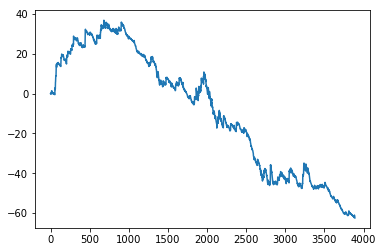

In [99]:
buy_log['gain'] = buy_log['close_price'] - buy_log['open_price'] - (buy_log['close_price'] + buy_log['open_price'])*2e-4

buy_log['gain'][:].cumsum().plot()

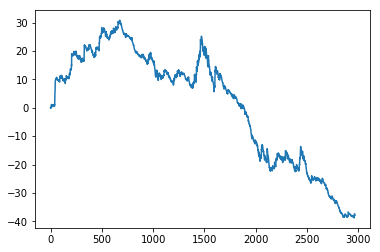

In [48]:
buy_log.iloc[620:650]

,Open_Clock,Close_Clock,open_price,close_price,gain
620,2020-03-10 13:19:00,2020-03-10 13:36:00,66.66,67.18,0.493232
621,2020-03-11 09:55:00,2020-03-11 09:56:00,66.83,66.60,-0.256686
622,2020-03-12 11:15:00,2020-03-12 11:25:00,61.80,61.71,-0.114702
623,2020-03-12 14:36:00,2020-03-12 14:54:00,60.97,61.25,0.255556
624,2020-03-13 10:29:00,2020-03-13 10:42:00,56.58,57.10,0.497264
625,2020-03-13 13:03:00,2020-03-13 13:27:00,57.38,58.29,0.886866
626,2020-03-13 14:40:00,2020-03-13 14:48:00,58.11,57.89,-0.243200
627,2020-03-16 11:02:00,2020-03-16 11:03:00,56.80,56.60,-0.222680
628,2020-03-17 09:34:00,2020-03-17 09:35:00,54.39,54.23,-0.181724
629,2020-03-17 09:49:00,2020-03-17 09:51:00,54.23,54.02,-0.231650


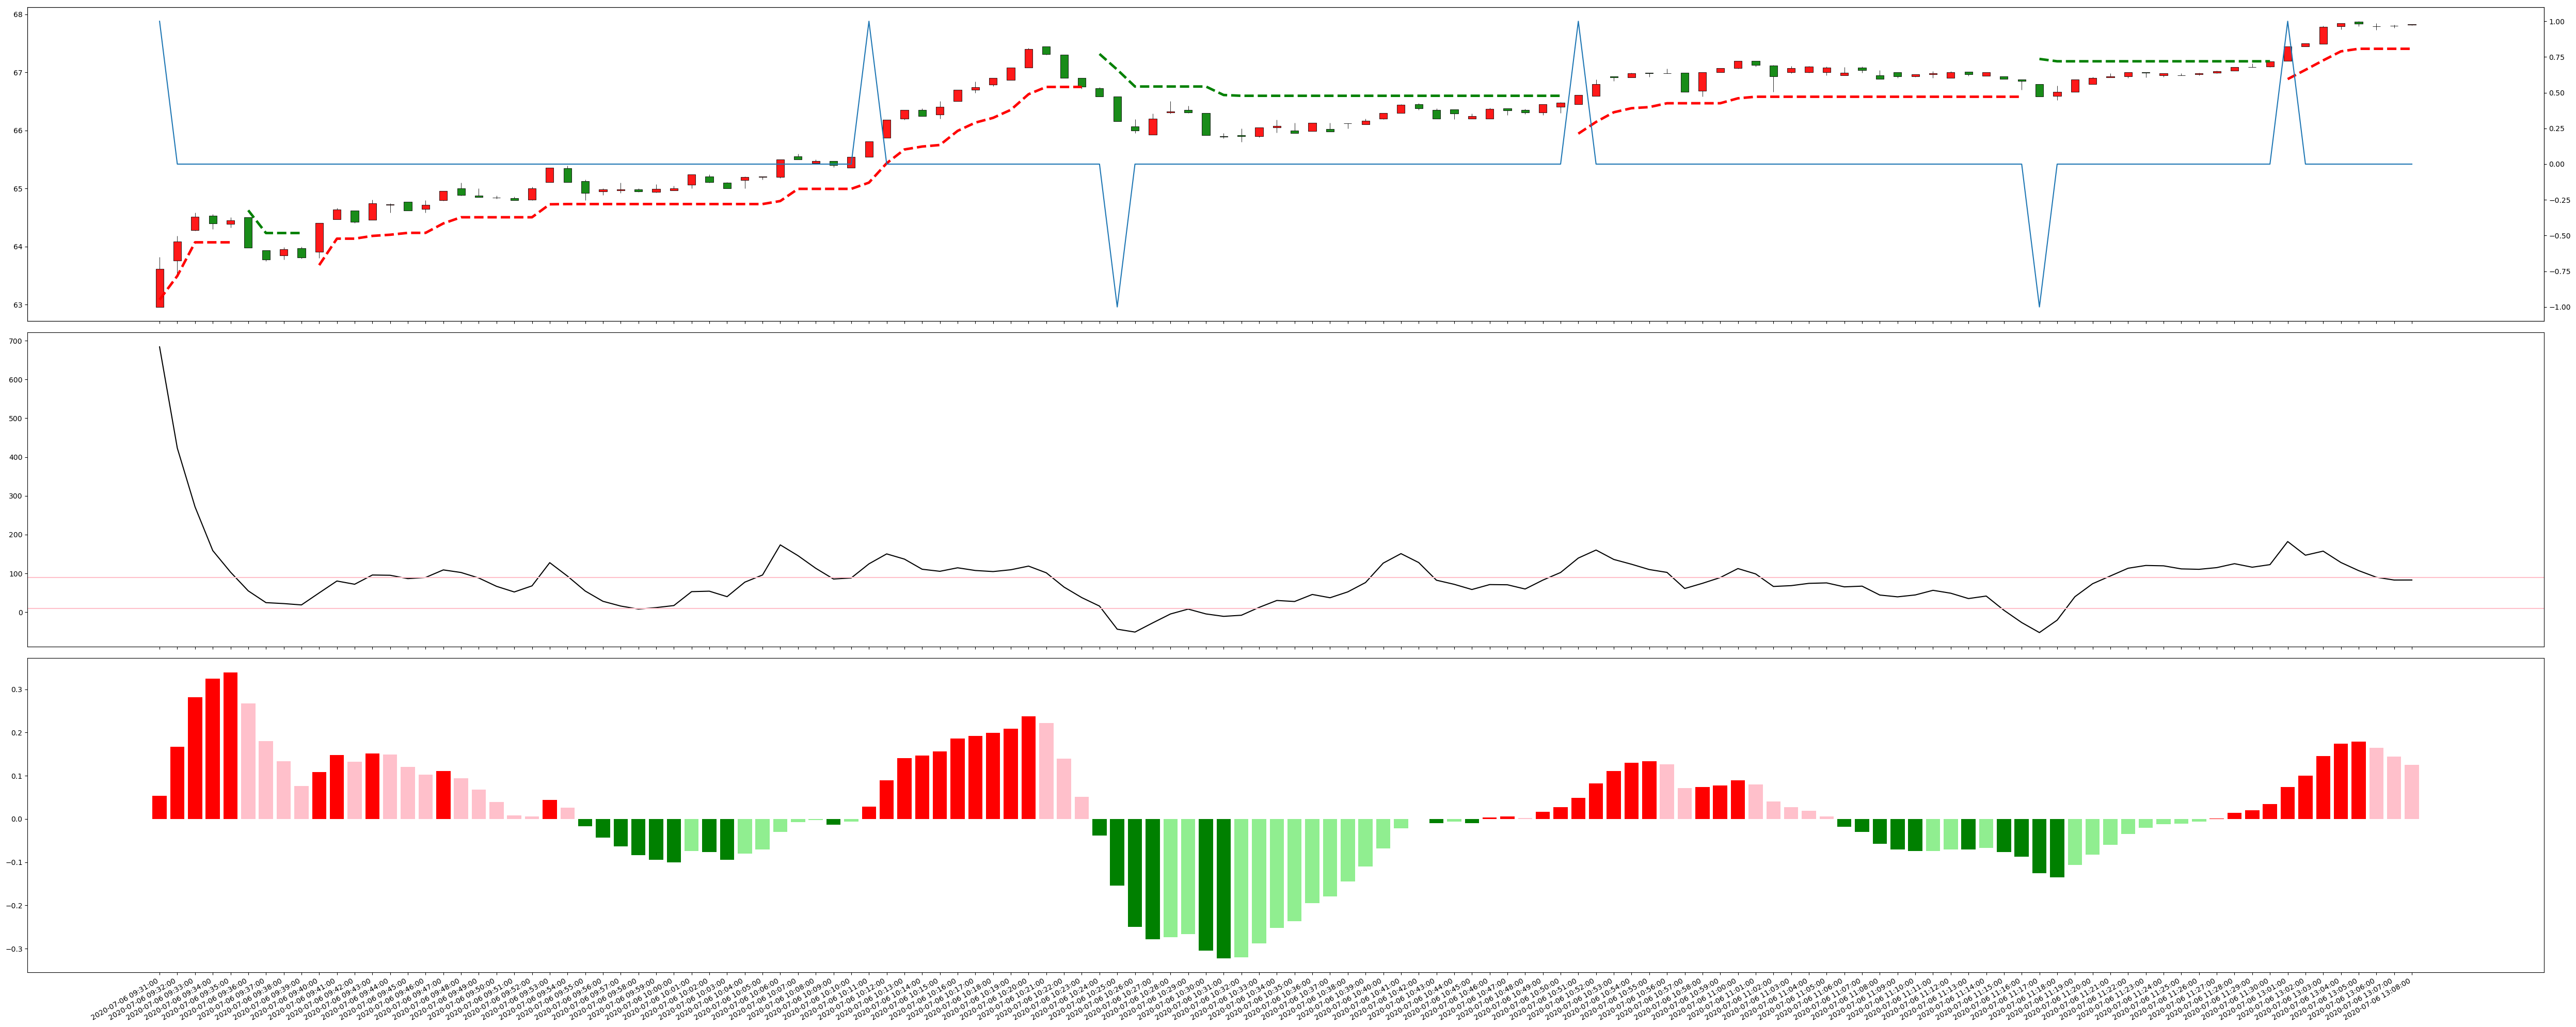

In [24]:
tmp_plot(ptmp, '2020-07-06 09:31:00','2020-07-06 13:08:00')

In [105]:
buy_exe_t  = list(ptmp['execution'].loc[ptmp['execution']== 1].index)
sell_exe_t = list(ptmp['execution'].loc[ptmp['execution']==-1].index)

sell_gain = []
for exe_t in tqdm(sell_exe_t, desc='Sell Execution'):

    if exe_t >= exe_t[:10] + ' 14:55:00':
        continue

    loss_cut = ptmp.loc[exe_t]['LOW']
    open_bar = str(pd.to_datetime(exe_t)+datetime.timedelta(minutes=1))
    open_bar = solid_bar_time(open_bar[:10], open_bar)

    if ptmp.loc[open_bar]['OPEN'] < loss_cut: # Open Position Successfully
        open_price = ptmp.loc[open_bar]['OPEN']

        close_bar = open_bar
        ## Longest Holding period: inf minutes
        for i in range(10000):
            ht = str(pd.to_datetime(open_bar)+datetime.timedelta(minutes=i))
            ht = solid_bar_time(ht[:10], ht)

            if ht >= exe_t[:10] + ' 14:55:00': # day out
                close_bar = exe_t[:10] + ' 14:55:00'
                break

            if ptmp.loc[ht]['CLOSE'] > loss_cut: # higher than loss tolerance level
                close_bar = ht
                break

            if ptmp.loc[ht]['J'] > 90: # J is too large
                close_bar = ht
                break

            if ht in buy_exe_t: # close sell position before trying to open buy position
                close_bar = ht
                break

            if ptmp.loc[ht]['MACD_color'] == 1: # Deep Red bars indicate the time to change loss cut
                loss_cut = min(loss_cut, ptmp.loc[ht]['HIGH'])

            if ht in sell_exe_t: # no appendant position befor closing
                del sell_exe_t[sell_exe_t.index(ht)]
                
        close_bar = str(pd.to_datetime(close_bar)+datetime.timedelta(minutes=1))
        close_bar = solid_bar_time(close_bar[:10], close_bar)
        close_price = ptmp.loc[close_bar]['OPEN'] # Close position using OPEN of bar_{t+1}

        sell_gain.append(open_price-close_price)

    else:
        continue 

Sell Execution:  24%|██▍       | 6319/26010 [01:43<05:21, 61.29it/s]


In [129]:
buy_gains = pd.Series(buy_gain)

In [127]:
list(pd.Series(buy_gain).cumsum())

[0.07000000000000028,
 0.03999999999999915,
 0.020000000000003126,
 0.11000000000000654,
 0.2400000000000091,
 0.4000000000000057,
 0.44000000000000483,
 0.5200000000000102,
 0.5400000000000134,
 0.5200000000000173,
 0.5600000000000165,
 0.5400000000000134,
 0.5800000000000125,
 0.690000000000019,
 0.8700000000000188,
 0.950000000000017,
 0.920000000000023,
 -0.8199999999999719,
 -0.38999999999997215,
 -0.6299999999999741,
 -0.5799999999999699,
 -0.049999999999968736,
 0.4100000000000321,
 0.4700000000000273,
 0.5300000000000296,
 0.5800000000000267,
 0.660000000000025,
 0.7400000000000304,
 0.8900000000000361,
 1.3300000000000338,
 1.630000000000031,
 1.620000000000033,
 1.8200000000000287,
 2.0200000000000315,
 1.860000000000035,
 2.0600000000000307,
 2.2400000000000304,
 2.2200000000000273,
 2.380000000000031,
 2.5800000000000267,
 2.590000000000032,
 2.390000000000036,
 2.590000000000039,
 2.4600000000000364,
 2.7200000000000344,
 2.9600000000000364,
 3.100000000000037,
 3.20000000

In [76]:
'2019-07-08 15:01:00' in buy_exe_t

False

Temp Plot Function

In [18]:
def tmp_plot(ptmp, t1, t2):
    smp_slice = ptmp.loc[t1: t2]

    fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize=(50, 20), dpi=100, sharex=True)
    # ptmp['UB'].loc[ptmp['STD']==-1.0] = np.nan
    # ptmp['LB'].loc[ptmp['STD']==1.0] = np.nan
    smp_slice['UB'].plot(ax=axes[0], color='g', linewidth=3.5, linestyle='--')
    smp_slice['LB'].plot(ax=axes[0], color='r', linewidth=3.5, linestyle='--')

    # ptmp['CLOSE'].loc[180:280].plot(ax=axes, color='b')
    sdf = pd.DataFrame()
    sdf['CLOCK'] = smp_slice['CLOCK'].apply(lambda x: pd.to_datetime(x))
    sdf = sdf.set_index('CLOCK')
    sdf['Open'] = smp_slice['OPEN']
    sdf['Close'] = smp_slice['CLOSE']
    sdf['High'] = smp_slice['HIGH']
    sdf['Low'] = smp_slice['LOW']
    sdf['Volume'] = smp_slice['VOLUME']

    mc = mpf.make_marketcolors(up='red', down='green', edge='black')
    s = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc, y_on_right=False)

    mpf.plot(sdf, ax = axes[0], type='candle', style = s, ylabel='')

    smp_slice['J'].plot(ax = axes[1], color='black')
    axes[1].axhline(y=90, color='pink')
    axes[1].axhline(y=10, color='pink')

    axes[2].bar(smp_slice['CLOCK'].to_list(), smp_slice['MACD_dr'], color = 'red')
    axes[2].bar(smp_slice['CLOCK'].to_list(), smp_slice['MACD_lr'], color = 'pink')
    axes[2].bar(smp_slice['CLOCK'].to_list(), smp_slice['MACD_dg'], color = 'green')
    axes[2].bar(smp_slice['CLOCK'].to_list(), smp_slice['MACD_lg'], color = 'lightgreen')

    ax_twin = axes[0].twinx()
    smp_slice['execution'].plot(ax=ax_twin)

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

+ Most operations in *basic_LS* are to decide when to close existing positions.

In [185]:
def basic_LS(_smp, account, _fees = True):
    _date = _smp['CLOCK'][0][:10]
    V1 = 100*int(((account/_smp['BS_price'][0])*0.1)/100)
    
    def solid_bar_time(_time):
        if (_date + ' 11:30:00' < _time) and (_time < _date + ' 13:00:00'):
            _time = str(pd.to_datetime(_time) + datetime.timedelta(hours=1, minutes=30))

        if _time == _date + ' 13:00:00':
            _time = str(pd.to_datetime(_time) + datetime.timedelta(minutes=1))
                    
        return _time

    pos_trading_points = _smp[:_date+' 14:55:00'].loc[(_smp['execution'] == 1)]['CLOCK'].to_list()
    neg_trading_points = _smp[:_date+' 14:55:00'].loc[(_smp['execution'] == -1)]['CLOCK'].to_list()

    _smp['Position'] = np.zeros(_smp.shape[0])
    _smp['close_reason'] = np.zeros(_smp.shape[0])

    ## Gains from positive forks
    pos_fork_gains = []
    last_close_buy_bar = str(pd.to_datetime(_smp['CLOCK'][0]) - datetime.timedelta(minutes=3))
    long_num = 0
    for t1 in pos_trading_points:
        open_buy_bar = solid_bar_time(str(pd.to_datetime(t1) + datetime.timedelta(minutes=1)))
        open_buy_price = _smp.loc[open_buy_bar]['OPEN']

        # at most 5 short executions
        if long_num > 5:
            break

        # Do not open again within 3 mins
        if open_buy_bar < str(pd.to_datetime(last_close_buy_bar) + datetime.timedelta(minutes=3)):
            continue

        # max holding period: inf min 
        for i in range (1, 1000): 
            buy_bar_ft = solid_bar_time(str(pd.to_datetime(open_buy_bar) + datetime.timedelta(minutes=i-1)))
            close_buy_bar = solid_bar_time(str(pd.to_datetime(open_buy_bar) + datetime.timedelta(minutes=i)))
            buy_bar_bt = solid_bar_time(str(pd.to_datetime(open_buy_bar) + datetime.timedelta(minutes=i+1)))
            last_close_buy_bar = close_buy_bar

            if close_buy_bar in pos_trading_points: # No appendant position
                del pos_trading_points[pos_trading_points.index(close_buy_bar)]

            # latest close time
            if close_buy_bar >= _date + ' 14:55:00':
                close_buy_bar = _date + ' 14:55:00'
                close_buy_price = _smp.loc[_date + ' 14:55:00']['OPEN']
                _smp['close_reason'][close_buy_bar] = 1 # close reason 1
                break

            # Trend Weaken interrupt
            if (_smp.loc[close_buy_bar]['signal3'] == -1.0):
                close_buy_bar = buy_bar_bt
                close_buy_price = _smp.loc[buy_bar_bt]['OPEN']
                _smp['close_reason'][close_buy_bar] = 2 # close reason 2
                break

            if _smp.loc[close_buy_bar]['Fluct'] <= FLUCT_TS:
                close_buy_bar = buy_bar_bt
                close_buy_price = _smp.loc[buy_bar_bt]['OPEN']
                _smp['close_reason'][close_buy_bar] = 3 # close reason 3
                break

            # # Volume decrease interrupt
            # if (_smp.loc[buy_bar_ft]['Vol_mom'] == 1.0) or (_smp.loc[close_buy_bar]['Vol_mom'] == 1.0):
            #     if (_smp.loc[close_buy_bar]['CLOSE']-_smp.loc[close_buy_bar]['OPEN'] < -1*REVERSE_MUL*_smp.loc[close_buy_bar]['ATR']):
            #         close_buy_bar = buy_bar_bt
            #         close_buy_price = _smp.loc[buy_bar_bt]['OPEN']
            #         _smp['close_reason'][close_buy_bar] = 4 # close reason 4
            #         break

            # profit interrupt 
            if float(_smp.loc[close_buy_bar]['CLOSE']) >= _smp.loc[close_buy_bar]['H_max'] + PROFIT_INTERRUPT_MUL * _smp.loc[close_buy_bar]['ATR']:
                close_buy_bar = buy_bar_bt
                close_buy_price = _smp.loc[buy_bar_bt]['OPEN']
                _smp['close_reason'][close_buy_bar] = 5 # close reason 5
                break

            # loss interrupt 
            if float(_smp.loc[close_buy_bar]['CLOSE']) <= _smp.loc[close_buy_bar]['P_L_MA'] - LOSS_INTERRUPT_MUL * _smp.loc[close_buy_bar]['ATR']:
                close_buy_bar = buy_bar_bt
                close_buy_price = _smp.loc[buy_bar_bt]['OPEN']
                _smp['close_reason'][close_buy_bar] = 6 # close reason 6
                break

        else:
            print(f"Error: No interrupt -- {_smp['SYMBOL'][0]-{_date}}")
            close_buy_price = _smp.loc[close_buy_bar]['OPEN']

        _smp['Position'][open_buy_bar:close_buy_bar] = 1
        long_num += 1

        # profits
        if _fees:
            profit_pos = (close_buy_price - open_buy_price) * V1 - (close_buy_price + open_buy_price) * V1 * 2e-4
        else:
            profit_pos = (close_buy_price - open_buy_price) * V1 

        pos_fork_gains.append(round(profit_pos, 4))

    ## Gains from negative forks
    neg_fork_gains = []
    last_close_sell_bar = str(pd.to_datetime(_smp['CLOCK'][0]) - datetime.timedelta(minutes=3))
    short_num = 0
    for t2 in neg_trading_points:
        open_sell_bar = solid_bar_time(str(pd.to_datetime(t2) + datetime.timedelta(minutes=1)))
        open_sell_price = _smp.loc[open_sell_bar]['OPEN']

        # at most 5 short executions
        if short_num > 5: 
            break

        # Do not open again within 3 mins
        if open_sell_bar < str(pd.to_datetime(last_close_sell_bar) + datetime.timedelta(minutes=3)):
            continue

        # max holding period: inf min
        for i in range (1, 1000):
            sell_bar_ft = solid_bar_time(str(pd.to_datetime(open_sell_bar) + datetime.timedelta(minutes=i-1)))
            close_sell_bar = solid_bar_time(str(pd.to_datetime(open_sell_bar) + datetime.timedelta(minutes=i)))
            sell_bar_bt = solid_bar_time(str(pd.to_datetime(open_sell_bar) + datetime.timedelta(minutes=i+1)))
            last_close_sell_bar = close_sell_bar

            if close_sell_bar in neg_trading_points:
                del neg_trading_points[neg_trading_points.index(close_sell_bar)]

            # latest close time
            if close_sell_bar >= _date + ' 14:55:00':
                close_sell_bar = _date + ' 14:55:00'
                close_sell_price = _smp.loc[_date + ' 14:55:00']['OPEN']
                _smp['close_reason'][close_sell_bar] = 1 # close reason 1
                break

            # Trend Weaken interrupt
            if (_smp.loc[close_sell_bar]['signal3'] == 1.0): 
                close_sell_bar = sell_bar_bt
                close_sell_price = _smp.loc[sell_bar_bt]['OPEN']
                _smp['close_reason'][close_sell_bar] = 2 # close reason 2
                break

            if _smp.loc[close_sell_bar]['Fluct'] <= FLUCT_TS:
                close_sell_bar = sell_bar_bt
                close_sell_price = _smp.loc[sell_bar_bt]['OPEN']
                _smp['close_reason'][close_sell_bar] = 3 # close reason 3
                break

            # # Volume decrease interrupt
            # if (_smp.loc[sell_bar_ft]['Vol_mom'] == 1.0) or (_smp.loc[close_sell_bar]['Vol_mom'] == 1.0):
            #     if (_smp.loc[close_sell_bar]['CLOSE']-_smp.loc[close_sell_bar]['OPEN'] > REVERSE_MUL*_smp.loc[close_sell_bar]['ATR']):
            #         close_sell_bar = sell_bar_bt
            #         close_sell_price = _smp.loc[sell_bar_bt]['OPEN']
            #         _smp['close_reason'][close_sell_bar] = 4 # close reason 4
            #         break

            # profit interrupt 
            if float(_smp.loc[close_sell_bar]['CLOSE']) <= _smp.loc[close_sell_bar]['L_min'] - PROFIT_INTERRUPT_MUL * _smp.loc[close_sell_bar]['ATR']:
                close_sell_bar = sell_bar_bt
                close_sell_price = _smp.loc[sell_bar_bt]['OPEN']
                _smp['close_reason'][close_sell_bar] = 5 # close reason 5
                break

            # loss interrupt 
            if float(_smp.loc[close_sell_bar]['CLOSE']) >= _smp.loc[close_sell_bar]['P_L_MA'] + LOSS_INTERRUPT_MUL * _smp.loc[close_sell_bar]['ATR']:
                close_sell_bar = sell_bar_bt
                close_sell_price = _smp.loc[sell_bar_bt]['OPEN']
                _smp['close_reason'][close_sell_bar] = 6 # close reason 6
                break
            
        else:
            close_sell_price = _smp.loc[close_sell_bar]['OPEN']

        _smp['Position'][open_sell_bar:close_sell_bar] = -1
        short_num += 1

        # profits
        if _fees:
            profit_neg = (open_sell_price - close_sell_price) * V1 - (close_sell_price + open_sell_price) * V1 * 2e-4
        else:
            profit_neg = (open_sell_price - close_sell_price) * V1 

        neg_fork_gains.append(round(profit_neg, 4))

    return [_date, pd.Series(pos_fork_gains), pd.Series(neg_fork_gains)], _smp

### BackTest

In [186]:
def one_stock_simulation(stock_id, stmp, logger=False, mode='backtest'):
    trading_log = pd.DataFrame(columns=['DATE', 'pos_fork_gains', 'neg_fork_gains'])

    if stmp.shape[0] == 0:
        trading_log.loc[trading_log.shape[0]] = ['2019-12-02', pd.Series([]), pd.Series([])]
        trading_log = trading_log.set_index('DATE', drop=False)
        trading_log = trading_log.reindex(Weight_Matrix.index).fillna(0)
        return (stock_id, [list(trading_log['pos_fork_gains_sum']), list(trading_log['neg_fork_gains_sum']), list(trading_log['total_gains_sum'])])

    stmp = stmp.set_index('CLOCK', drop=False)

    Start_date = max('2019-11-29 00:00:00', stmp['CLOCK'][0])
    End_date = min('2022-07-01 15:00:00', stmp['CLOCK'][-1])

    stmp = stmp.loc[(Start_date <= stmp['CLOCK']) & (stmp['CLOCK'] <= End_date)]
    stmp = stmp[~stmp.index.duplicated()]

    r_stmp = pd.DataFrame()

    if logger: print(f'Calculating Technical Features of [{stock_id}]...')
    ftmp = technical_analysis(stmp, log=logger)
    if logger: print('Done')

    ftmp = ftmp.loc[str(pd.to_datetime(Start_date)+datetime.timedelta(days=1))<= stmp['CLOCK']]
    ftmp['Position'] = np.zeros(ftmp.shape[0])

    VTD = list(ftmp['CLOCK'].apply(lambda x: x[:10]).drop_duplicates())

    if logger:
        for d in tqdm(VTD[:], desc='Basic_LS'):
            tmp_smp = ftmp.loc[(d+' 00:00:00' < ftmp['CLOCK']) & (ftmp['CLOCK'] < d+' 15:01:00')]
            entry, tmp_smp = basic_LS(tmp_smp, 1e8, _fees=True)
            r_stmp = r_stmp.append(tmp_smp)
            trading_log.loc[trading_log.shape[0]] = entry
    else:
        for d in VTD[:]:
            tmp_smp = ftmp.loc[(d+' 00:00:00' < ftmp['CLOCK']) & (ftmp['CLOCK'] < d+' 15:01:00')]
            entry, tmp_smp = basic_LS(tmp_smp, 1e8, _fees=True)
            r_stmp = r_stmp.append(tmp_smp)
            trading_log.loc[trading_log.shape[0]] = entry

    trading_log = trading_log.set_index('DATE', drop=False)
    trading_log = trading_log.reindex(Weight_Matrix.index).fillna(0)
    
    if logger: clear_output()
    
    if mode == 'backtest':
        return (stock_id, [list(trading_log['pos_fork_gains']), list(trading_log['neg_fork_gains'])])
    else:
        return (stock_id, [list(trading_log['pos_fork_gains']), list(trading_log['neg_fork_gains'])]), r_stmp

##### Single Symbol Simulation
+ Take 'S.CN.SZSE.300618', a relatively active stock for example

In [187]:
stmp_pp = Base_Pos['S.CN.SZSE.300618']

tmp_tup, ftmp_p = one_stock_simulation('S.CN.SZSE.300618', stmp_pp, True, 'eval')

In [145]:
ftmp_p['execution'].loc[ftmp_p['execution']!=0]

Series([], Name: execution, dtype: float64)

In [146]:
trading_log = pd.DataFrame(columns=['DATE', 'pos_fork_gains', 'neg_fork_gains'])
stmp = Base_Pos['S.CN.SZSE.300618']

stmp = stmp.set_index('CLOCK', drop=False)

Start_date = max('2019-11-29 00:00:00', stmp['CLOCK'][0])
End_date = min('2022-07-01 15:00:00', stmp['CLOCK'][-1])

stmp = stmp.loc[(Start_date <= stmp['CLOCK']) & (stmp['CLOCK'] <= End_date)]
stmp = stmp[~stmp.index.duplicated()]

r_stmp = pd.DataFrame()

ftmp = technical_analysis(stmp, MACD_activation, log=True)

[BS_price & ATR]          | 2022-08-09 17:25:36 Done | Using  5.186 seconds
[Price Mean]              | 2022-08-09 17:25:36 Done | Using  0.035 seconds
[Volume Mean]             | 2022-08-09 17:25:36 Done | Using  0.035 seconds
[MACD]                    | 2022-08-09 17:25:36 Done | Using  0.038 seconds
[Channel]                 | 2022-08-09 17:25:36 Done | Using  0.035 seconds
[Fluctuation]             | 2022-08-09 17:25:36 Done | Using  0.003 seconds
[SIGNAL 1: Price Forks]   | 2022-08-09 17:25:36 Done | Using  0.021 seconds
[SIGNAL 2: Volume Forks]  | 2022-08-09 17:25:36 Done | Using  0.021 seconds
[SIGNAL 3: MACD Forks]    | 2022-08-09 17:25:36 Done | Using  0.020 seconds
[Trend Involvment]        | 2022-08-09 17:26:50 Done | Using  73.341 seconds
[Volume Momentum]         | 2022-08-09 17:27:14 Done | Using  24.733 seconds
[Execution]               | 2022-08-09 17:27:14 Done | Using  0.026 seconds


In [151]:
ftmp['execution'] = np.zeros(ftmp.shape[0])

In [152]:
_date = ftmp['CLOCK'][0][:10]

In [164]:
ftmp['execution'].loc[ftmp['execution']!=0]

CLOCK
2019-12-02 09:48:00   -1.0
2019-12-02 10:11:00    1.0
2019-12-02 11:04:00    1.0
2019-12-03 14:32:00   -1.0
2019-12-04 10:38:00   -1.0
                      ... 
2022-06-29 10:14:00   -1.0
2022-07-01 09:37:00    1.0
2022-07-01 09:45:00   -1.0
2022-07-01 10:05:00    1.0
2022-07-01 14:55:00    1.0
Name: execution, Length: 2303, dtype: float64

##### Base Position Simulation
+ Simulate all symbols contained in base positions
+ Divide symbols into several batches and use joblib to parallelize the simulation

In [14]:
# BATCH_SIZE = 128 # Do not put all eggs in signal bucket
# res = []
# ## Parallel BackTest
# tasks = []
# for i in range(3, (len(Weight_Matrix.columns)//BATCH_SIZE + 1)):
#     with timer(f'Batch {i}: {BATCH_SIZE*i:3} -- {min(len(Weight_Matrix.columns), BATCH_SIZE*(i+1))-1:3}', 20, True):
#         for col in Weight_Matrix.columns[BATCH_SIZE*i:min(len(Weight_Matrix.columns), BATCH_SIZE*(i+1))]:
#             stmp_ = Base_Pos[col]
#             one_stock_simulation(col, stmp_, True)

In [15]:
# BATCH_SIZE = 128 # Do not put all eggs in one signal bucket
# res = []
# ## Parallel BackTest
# tasks = []
# for i in range(3, (len(Weight_Matrix.columns)//BATCH_SIZE + 1)):
#     with timer(f'Batch {i}: {BATCH_SIZE*i:3} -- {min(len(Weight_Matrix.columns), BATCH_SIZE*(i+1))-1:3}', True):
#         for col in Weight_Matrix.columns[BATCH_SIZE*i:min(len(Weight_Matrix.columns), BATCH_SIZE*(i+1))]:
#             stmp_ = Base_Pos[col]
#             tasks.append(delayed(one_stock_simulation)(col, stmp_))

#         multi_work = Parallel(n_jobs=-1)
#         res += multi_work(tasks)

In [16]:
# ## Check SYMBOL Order
# Rank_Order = True
# for a, b in zip(res, Weight_Matrix.columns):
#     if a[0] != b:
#         print(f'{a[0]} != {b}') 
#         Rank_Order = False
#         break
# else:
#     print('All Ranks Correct')

# Pos_Fork_Gains = pd.DataFrame()
# Pos_Fork_Gains = Pos_Fork_Gains.reindex(Weight_Matrix.index)

# Neg_Fork_Gains = pd.DataFrame()
# Neg_Fork_Gains = Neg_Fork_Gains.reindex(Weight_Matrix.index)

# Total_Gains = pd.DataFrame()
# Total_Gains = Total_Gains.reindex(Weight_Matrix.index)

# if Rank_Order:
#     ## Allocate Results
#     for item in res:
#         Pos_Fork_Gains[item[0]] = item[1][0]
#         Neg_Fork_Gains[item[0]] = item[1][1]
#         Total_Gains[item[0]] = item[1][2]

#     Pos_Fork_Gains_BS = pd.DataFrame(Pos_Fork_Gains.values * Weight_Matrix.values)
#     Neg_Fork_Gains_BS = pd.DataFrame(Neg_Fork_Gains.values * Weight_Matrix.values)
#     Total_Gains_BS = pd.DataFrame(Total_Gains.values * Weight_Matrix.values)

##### Basic Analysis

In [188]:
tmp_t_log = pd.DataFrame()
tmp_t_log.reindex(Weight_Matrix.index)
tmp_t_log['SYMBOL'] = tmp_tup[0]
tmp_t_log['pos_fork_gains'] = tmp_tup[1][0]
tmp_t_log['neg_fork_gains'] = tmp_tup[1][1]

+ Pnl

In [106]:
def Pnl_Cal(_trading_log, _account):
    _trading_log['pos_fork_gains_sum'] = _trading_log['pos_fork_gains'].apply(lambda x: x.sum())
    _trading_log['neg_fork_gains_sum'] = _trading_log['neg_fork_gains'].apply(lambda x: x.sum())
    _trading_log['total_gains_sum'] = _trading_log['pos_fork_gains_sum'] + _trading_log['neg_fork_gains_sum']

    _pos_fork_pnl = 1 + _trading_log['pos_fork_gains_sum'].cumsum()/_account
    _neg_fork_pnl = 1 + _trading_log['neg_fork_gains_sum'].cumsum()/_account
    _fork_pnl = 1 + _trading_log['total_gains_sum'].cumsum()/_account

    return _pos_fork_pnl, _neg_fork_pnl, _fork_pnl

In [189]:
pos_fork_pnl, neg_fork_pnl, fork_pnl = Pnl_Cal(tmp_t_log, 1e8)

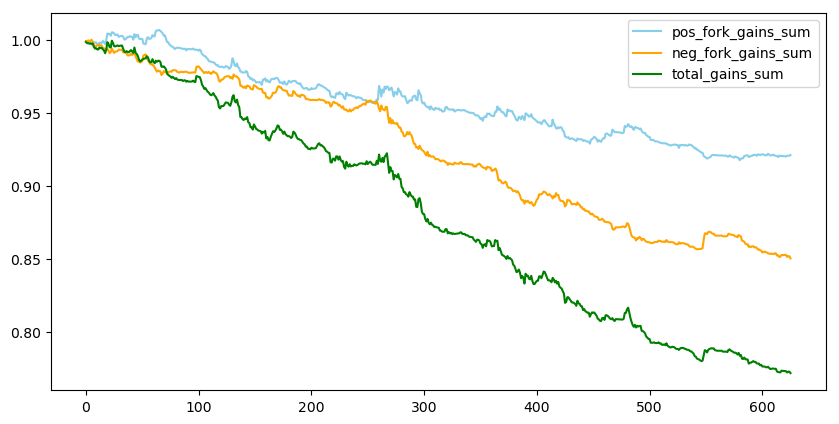

In [190]:
plt.figure(figsize=(10, 5), dpi=100)

pos_fork_pnl.plot(color='skyblue')
neg_fork_pnl.plot(color='orange')
fork_pnl.plot(color='green')

plt.legend()
# plt.title('Tipless Filter, Having Fees')

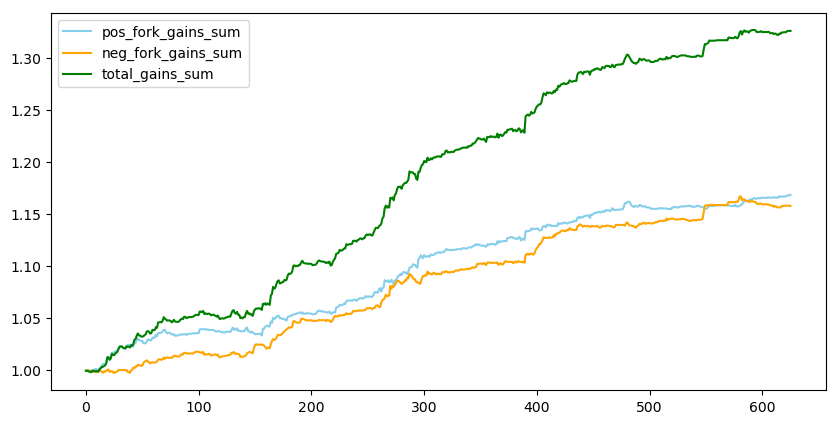

In [72]:
plt.figure(figsize=(10, 5), dpi=100)

pos_fork_pnl.plot(color='skyblue')
neg_fork_pnl.plot(color='orange')
fork_pnl.plot(color='green')

plt.legend()
# plt.title('Tipless Filter, Having Fees')

+ Win Rate

In [175]:
def cal_win_rate(_trading_log):
    daily_pos_fork_winrate = []
    daily_neg_fork_winrate = []

    pos_win = []
    pos_lose = []
    neg_win = []
    neg_lose = []

    for i in range(_trading_log.shape[0]):
        if _trading_log['pos_fork_gains'][i].shape[0]:
            _slice = _trading_log['pos_fork_gains'][i]
            daily_pos_fork_winrate.append(len(_slice.loc[_slice>0])/len(_slice))
            pos_win += list(_slice.loc[_slice>0])
            pos_lose += list(_slice.loc[_slice<0])
            
        if _trading_log['neg_fork_gains'][i].shape[0]:
            _slice = _trading_log['neg_fork_gains'][i]
            daily_neg_fork_winrate.append(len(_slice.loc[_slice>0])/len(_slice))
            neg_win += list(_slice.loc[_slice>0])
            neg_lose += list(_slice.loc[_slice<0])

    return daily_pos_fork_winrate, daily_neg_fork_winrate, (pos_win, pos_lose), (neg_win, neg_lose)

In [176]:
dpw, dnw, tpwl, tnwl = cal_win_rate(tmp_t_log)

In [177]:
print(f'Pos Fork Win Rate: {round(len(tpwl[0])/(len(tpwl[0])+len(tpwl[1])), 4)}')
print(f'Pos Fork Win-Loss Ratio: {round(np.abs(sum(tpwl[0]) / sum(tpwl[1])), 4)}\n')

print(f'Neg Fork Win Rate: {round(len(tnwl[0])/(len(tnwl[0])+len(tnwl[1])), 4)}')
print(f'Neg Fork Win-Loss Ratio: {round(np.abs(sum(tnwl[0]) / sum(tnwl[1])), 4)}\n')

print(f'Total Win Rate: {round((len(tpwl[0])+len(tnwl[0]))/(len(tpwl[0])+len(tpwl[1]) + len(tnwl[0])+len(tnwl[1])), 4)}')
print(f'Total Win-Loss Ratio: {round(np.abs((sum(tpwl[0]) + sum(tnwl[0]))/(sum(tpwl[1]) + sum(tnwl[1]))), 4)}')

Pos Fork Win Rate: 0.381
Pos Fork Win-Loss Ratio: 0.8207

Neg Fork Win Rate: 0.4076
Neg Fork Win-Loss Ratio: 0.7424

Total Win Rate: 0.3943
Total Win-Loss Ratio: 0.781


Text(0.5,1,'Neg Fork Win Rate')

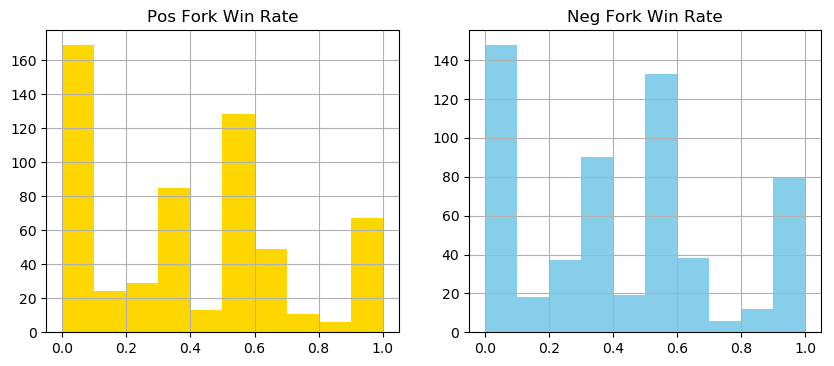

In [178]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=100)
pd.Series(dpw).hist(ax=axes[0], color='gold')
axes[0].set_title('Pos Fork Win Rate')
pd.Series(dnw).hist(ax=axes[1], color='skyblue')
axes[1].set_title('Neg Fork Win Rate')
# plt.suptitle('Having Filter, Having Fees')

In [179]:
def profitable_analysis(_pnl):
    Annual_r = (_pnl.diff()/_pnl.shift(1)).mean()*252
    Std = (_pnl.diff()/_pnl.shift(1)).std()*np.sqrt(252)
    Sharpe = Annual_r / Std
    MaxDrawdown = (1 - _pnl/pd.Series(list(_pnl.rolling(len(_pnl)))).apply(lambda x: x.max())).max()
    Calmar = Annual_r / MaxDrawdown
    return Annual_r, Std, Sharpe, MaxDrawdown, Calmar

In [180]:
profitable_analysis(fork_pnl)

(-0.09186989077933963,
 0.0283314882566199,
 -3.242677897722984,
 0.2069855917637572,
 -0.44384679144331574)

#### Plot and Analysis

+ Plot basic and calculated features of one single trading day.
+ Subplot 0: basic information including *Candle bars* and *Positions* (containing reasons why positions are closed)
+ Subplot 1: features related to signal 1 including *P_S_MA*, *P_L_MA*, *CLOSE*, and *Signal1*
+ Subplot 2: features related to signal 2 including *Volume*, *V_L_MA*, *V_S_MA* and *Signal2*
+ Subplot 3: features related to signal 3 including *DIF*, *DEA*, *Close* and *Signal3*
+ Subplot 4: features related to Fluctuations including *H_max*, *L_min*, *Fluct* and *FLUCT_TS*


In [107]:
def plot_all(smp):
    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(20, 15), dpi=200)

    ## SUBPLOT 0: Candle bars & Position
    axes[0].set_title('Candle bars & Position')
    axes[0].grid(False)
    axes[0].yaxis.set_ticks_position('left')

    sdf = pd.DataFrame()
    sdf['CLOCK'] = smp['CLOCK'].apply(lambda x: pd.to_datetime(x))
    sdf = sdf.set_index('CLOCK')
    sdf['Open'] = smp['OPEN']
    sdf['Close'] = smp['CLOSE']
    sdf['High'] = smp['HIGH']
    sdf['Low'] = smp['LOW']
    sdf['Volume'] = smp['VOLUME']

    mc = mpf.make_marketcolors(up='red', down='green', edge='black')
    s = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc, y_on_right=False)
    
    mpf.plot(sdf, ax = axes[0], type='candle', style = s, ylabel='')

    ax_twin0 = axes[0].twinx()
    ax_twin0.grid(False)
    ax_twin0.yaxis.set_ticks_position('right')

    ax_twin0.bar(smp['CLOCK'].to_list(), smp['Position'], color='pink', alpha=0.6, label='Position')
    Close_Reasons = ['day out', 'macd reverse', 'low fluct', 'vol_mom', 'profit cut', 'loss cut']
    for i in range(6):
        smp['close'] = np.zeros(smp.shape[0])
        smp['close'].loc[smp['close_reason']==i+1] = smp['Position'].loc[smp['close_reason']==i+1] 
        ax_twin0.bar(smp['CLOCK'].to_list(), smp['close'], color=COLORS[i], alpha=0.6, label=f'{Close_Reasons[i]}')

    ax_twin0.set_ylim(-1.0, 1.0)
    ax_twin0.legend(loc='center right')

    ## SUBPLOT 1: P_S_MA & P_L_MA & Close & Signal 1
    axes[1].set_title('Signal 1')
    axes[1].grid(False)
    axes[1].yaxis.set_ticks_position('left')

    smp['CLOSE'].plot(ax=axes[1], color='b')
    smp['P_S_MA'].plot(ax=axes[1], color='orange')
    smp['P_L_MA'].plot(ax=axes[1], color='g')
    axes[1].legend(loc = 'upper left')

    ax_twin1 = axes[1].twinx()
    ax_twin1.grid(False)
    ax_twin1.yaxis.set_ticks_position('right')

    smp['signal1'].plot(alpha=0.5, ax = ax_twin1, color='skyblue') 
    ax_twin1.set_ylim(-1.0, 1.0)
    ax_twin1.legend(loc='upper right')

    ## SUBPLOT 2: Volume & V_L_MA & V_S_MA & Signal 2
    axes[2].set_title('Signal 2')
    axes[2].grid(False)
    axes[2].yaxis.set_ticks_position('left')

    axes[2].bar(smp['CLOCK'].to_list(), smp['VOLUME'], color='purple', alpha=0.3, label='Volume')
    # smp['V_S_MA'].plot(ax=axes[2], color='orange')
    # smp['V_L_MA'].plot(ax=axes[2], color='g')
    axes[2].legend(loc = 'upper left')

    ax_twin2 = axes[2].twinx()
    ax_twin2.grid(False)
    ax_twin2.yaxis.set_ticks_position('right')

    smp['signal2'].plot(alpha=0.5, ax = ax_twin2, color='skyblue')
    ax_twin2.set_ylim(-1.0, 1.0)
    ax_twin2.legend(loc='upper right')

    ## SUBPLOT 3: DIF & DEA & Close & Signal 3
    axes[3].set_title('Signal 3')
    axes[3].grid(False)
    axes[3].yaxis.set_ticks_position('left')

    smp['DIF'].plot(ax=axes[3], color='orange')
    smp['DEA'].plot(ax=axes[3], color='g')
    axes[3].legend(loc = 'upper left')

    ax_twin3 = axes[3].twinx()
    ax_twin3.grid(False)
    ax_twin3.yaxis.set_ticks_position('right')

    smp['signal3'].plot(alpha=0.5, ax = ax_twin3, color='skyblue')
    ax_twin3.set_ylim(-1.0, 1.0)
    ax_twin3.legend(loc='upper right')

    ## SUBPLOT 4: Fluctuation
    axes[4].set_title('Fluctuation')
    axes[4].grid(False)
    axes[4].yaxis.set_ticks_position('left')

    smp['H_max'].plot(ax=axes[4], color='orange')
    smp['CLOSE'].plot(ax=axes[4], color='b')
    smp['L_min'].plot(ax=axes[4], color='g')
    
    ax_twin4 = axes[4].twinx()
    ax_twin4.grid(False)
    ax_twin4.yaxis.set_ticks_position('right')

    smp['fluct_ts'] = FLUCT_TS
    smp['Fluct'].plot(alpha=0.5, ax = ax_twin4, color='skyblue')
    smp['fluct_ts'].plot(alpha=0.5, ax = ax_twin4, color = 'hotpink')
    ax_twin4.legend(loc='upper right')
    
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

In [182]:
def one_day_micro(_ftmp, _date):
    start_clock = _date + ' 00:00:00'
    end_clock = str(pd.to_datetime(start_clock) + datetime.timedelta(days = 1))
    plot_all(_ftmp.loc[(start_clock < ftmp_p['CLOCK']) & (ftmp_p['CLOCK'] < end_clock)])

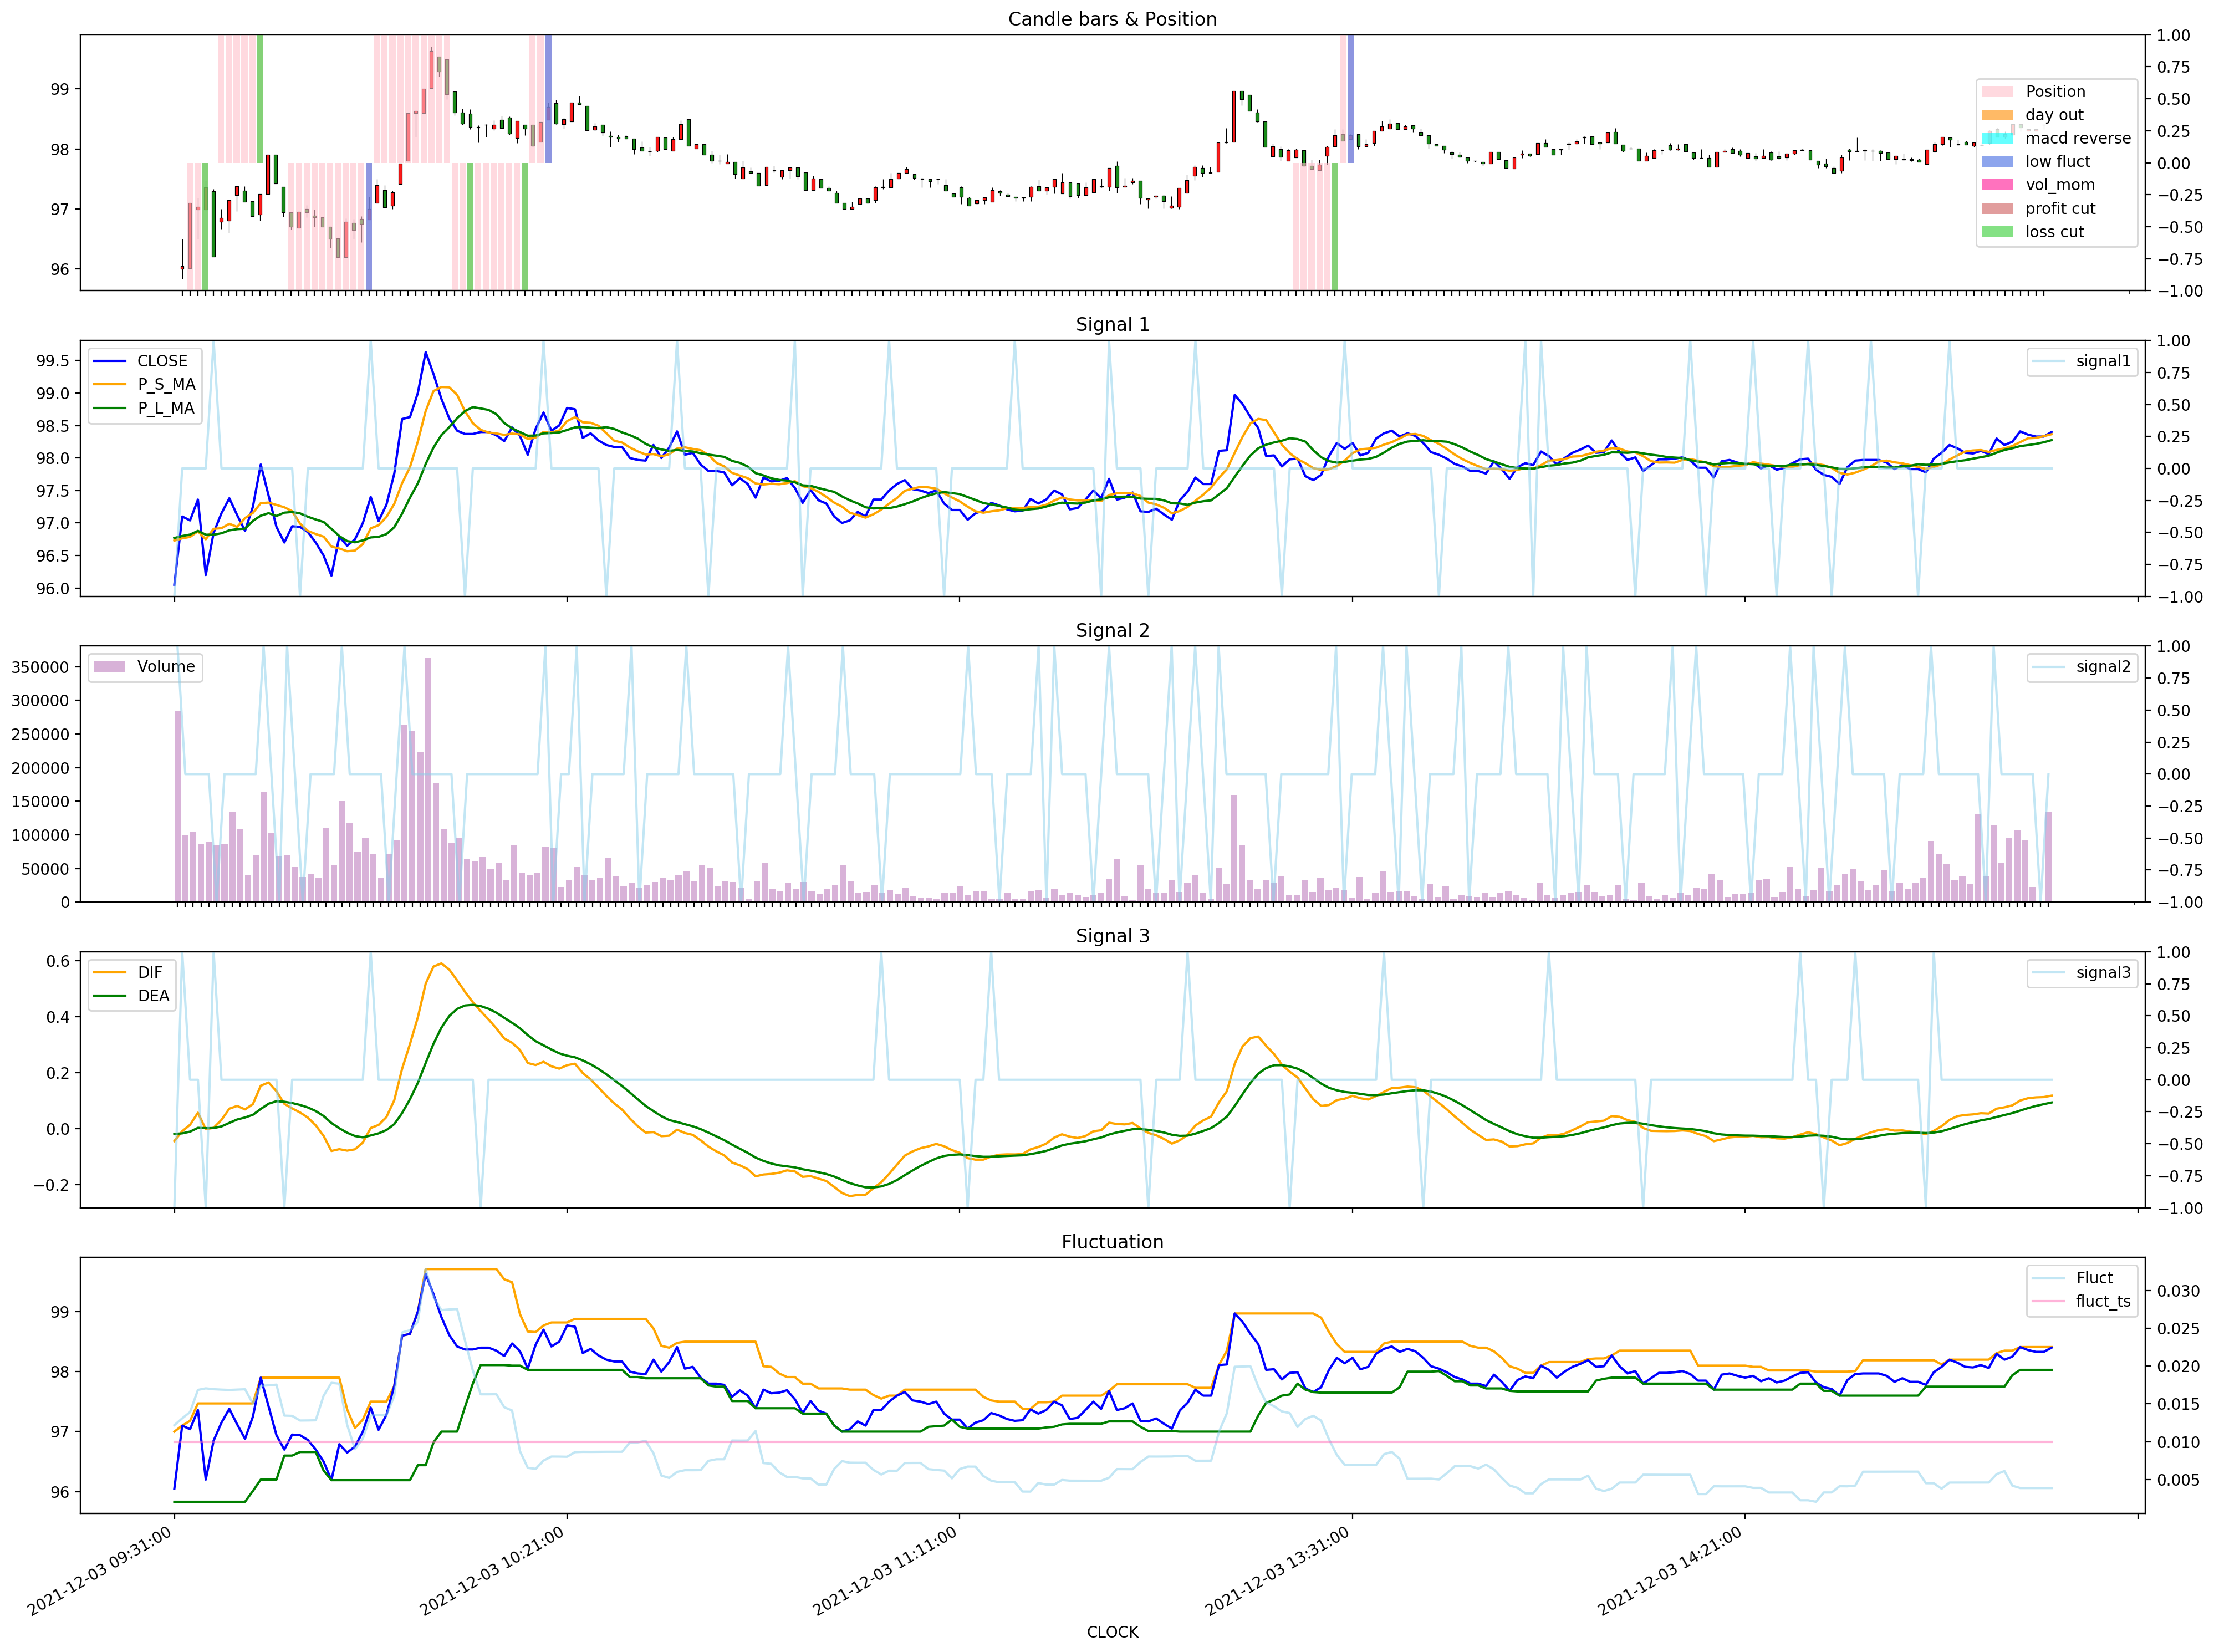

In [193]:
one_day_micro(ftmp_p, '2021-12-03')